In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


# 2.1.1 缺失值检测、异常值检测与数据类型转换

In [73]:
data = pd.read_csv('adult.csv')
print("缺失值统计：")
print(data.isnull().sum())

缺失值统计：
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


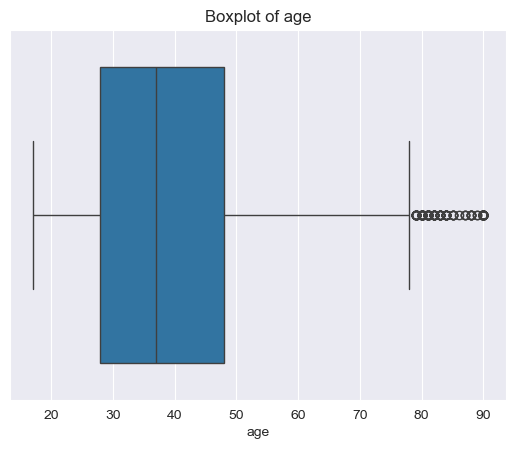

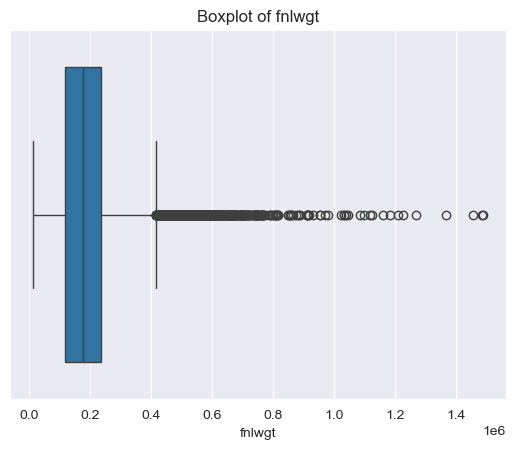

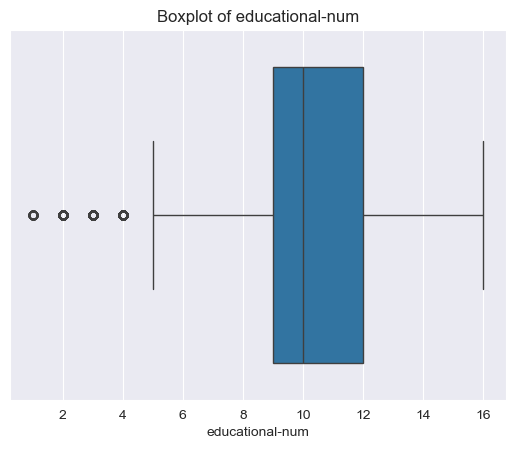

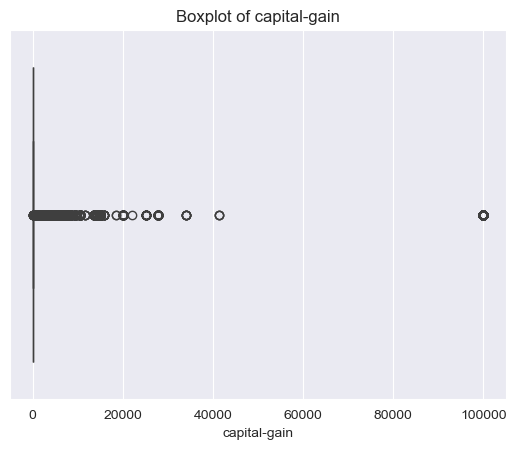

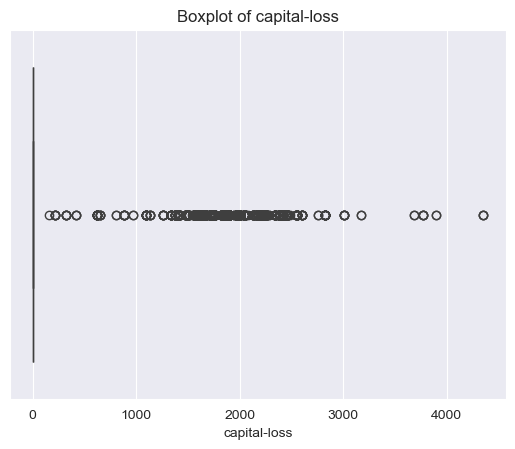

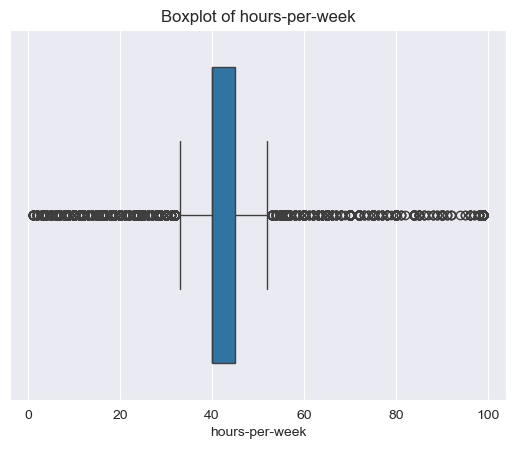

In [74]:
numeric_features = data.select_dtypes(include=[np.number]).columns
for col in numeric_features:
    plt.figure()
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

### 用中位数填充数值型缺失值

In [75]:
num_imputer = SimpleImputer(strategy='median')
data[numeric_features] = num_imputer.fit_transform(data[numeric_features])

In [76]:
selected_features = ['relationship','marital-status','occupation','educational-num'] 
df = data[selected_features]

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = data.drop('income', axis=1)
y = data['income'].map({'<=50K': 0, '>50K': 1})

vectorizers = {}
tfidf_matrices = []
text_columns = ['relationship', 'marital-status', 'occupation']
for col in text_columns:
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(df[col].fillna(''))
    vectorizers[col] = vectorizer
    tfidf_matrices.append(tfidf)

from scipy.sparse import hstack
X_tfidf = hstack(tfidf_matrices)


# 2.1.3 模型构建(knn)

In [78]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_tfidf, y, test_size=0.25, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]


# 2.1.4 模型评估

### 准确率, 精确率, 召回率, F1分数

In [79]:
accuracy = accuracy_score(y_test, y_pred)
precision = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1)
recall = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)
F1_score = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {F1_score:.2f}")

Accuracy: 0.78
Precision: 0.53
Recall: 0.35
F1 Score: 0.42


### 混淆矩阵

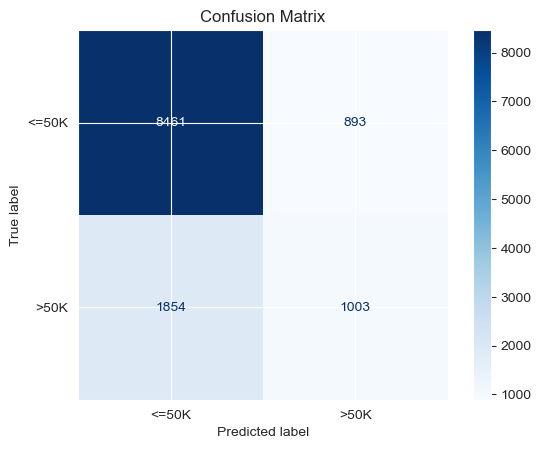

In [80]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### ROC曲线

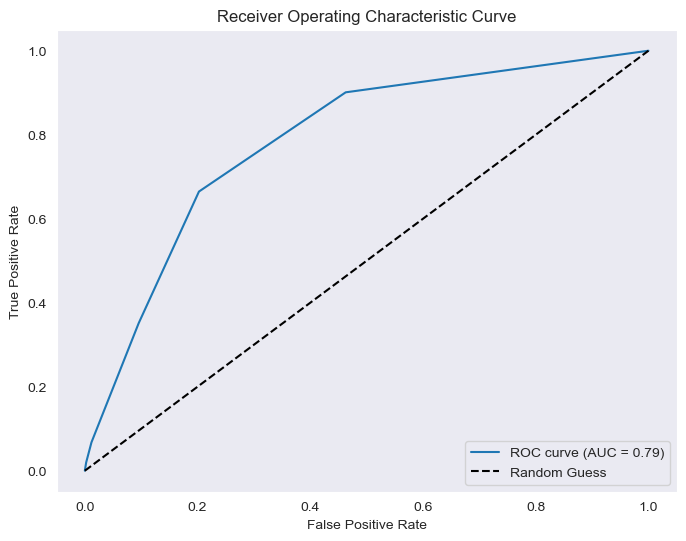

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()